# Step 4: Model Taxonomical Species
### Run in Google Colab

In [1]:
# Imports & Setup:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import PIL
import PIL.Image
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

%matplotlib inline

import warnings

warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(42)

from google.colab import drive
drive.mount('/content/drive')

import tarfile

fname = "/content/drive/MyDrive/CUB_200_2011.tgz"
fobj = tarfile.open(fname, "r")
fobj.extractall("/content")
fobj.close()

# function to load in and process images
def load_image(path):
    images = Image.open(f'/content/CUB_200_2011/images/{path}') 
    new_image=images.resize((128,128))
    color_image=new_image.convert("RGB")
    arrays1 = np.asarray(color_image)
    floaters= arrays1.astype('float32')
    floaters2=floaters/255.0
    return floaters2

class_map_dir= pd.read_csv('/content/drive/MyDrive/Bird-Classifications/Tables/class_map_taxonomy_directory.csv')

# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (128, 128)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
#base_model.summary()

class_map_dir_train=class_map_dir.loc[class_map_dir['Is Training Image']==1]
list_of_images_train=[load_image(i) for i in class_map_dir_train['Image Name']]
array_of_img_train=np.asarray(list_of_images_train)
list_of_labels_train=class_map_dir_train['Class Id']

class_map_dir_test=class_map_dir.loc[class_map_dir['Is Training Image']==0]
list_of_images_test=[load_image(i) for i in class_map_dir_test['Image Name']]
array_of_img_test=np.asarray(list_of_images_test)
list_of_labels_test=class_map_dir_test['Class Id']

# sanity check length of train datasets
print(len(list_of_images_train))
print(len(list_of_labels_train))

# sanity check length of test datasets
print(len(list_of_images_test))
print(len(list_of_labels_test))

X_train_alt=array_of_img_train
y_train_alt=list_of_labels_train

X_test_alt=array_of_img_test
y_test_alt=list_of_labels_test

X_train_alt = X_train_alt.reshape(X_train_alt.shape[0], 128, 128, 3)
X_test_alt = X_test_alt.reshape(X_test_alt.shape[0], 128, 128, 3)
y_train_alt = utils.to_categorical(y_train_alt,201)
y_test_alt = utils.to_categorical(y_test_alt,201)

Mounted at /content/drive
9420800/9406464 [==============================] - 0s 0us/step
5994
5994
5794
5794


In [2]:
model_t = Sequential([ base_model,
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.15),
])

model_t.add(Flatten(input_shape = (128, 128, 3)))
model_t.add(Dense(256, activation = 'relu'))
model_t.add(Dense(256, activation = 'relu'))
model_t.add(Dropout(0.1))
model_t.add(Dense(128, activation = 'relu'))
model_t.add(Dense(64, activation = 'relu'))
model_t.add(Dropout(0.1))
model_t.add(Dense(64, activation = 'relu'))
model_t.add(Dropout(0.2))
model_t.add(Dense(48, activation = 'relu'))

model_t.add(Dense(201, activation = 'softmax'))
# Compile model.
model_t.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_t.trainable = True
early_stop = EarlyStopping(monitor = 'val_accuracy', min_delta=0, patience = 8, verbose = 1, mode = 'auto')
history_t  = model_t.fit(X_train_alt,
                    y_train_alt, 
                    batch_size=256,
                    validation_data=(X_test_alt, y_test_alt),
                    epochs=200,
                    verbose=1,
                    callbacks = [early_stop])

Epoch 1/200
24/24 [==============================] - 17s 268ms/step - loss: 5.3294 - accuracy: 0.0065 - val_loss: 5.2773 - val_accuracy: 0.0112
Epoch 2/200
24/24 [==============================] - 5s 196ms/step - loss: 5.2616 - accuracy: 0.0112 - val_loss: 5.1678 - val_accuracy: 0.0166
Epoch 3/200
24/24 [==============================] - 4s 161ms/step - loss: 5.0683 - accuracy: 0.0189 - val_loss: 4.8472 - val_accuracy: 0.0280
Epoch 4/200
24/24 [==============================] - 5s 196ms/step - loss: 4.7281 - accuracy: 0.0319 - val_loss: 4.4412 - val_accuracy: 0.0488
Epoch 5/200
24/24 [==============================] - 4s 161ms/step - loss: 4.3819 - accuracy: 0.0509 - val_loss: 4.1716 - val_accuracy: 0.0758
Epoch 6/200
24/24 [==============================] - 5s 196ms/step - loss: 4.0677 - accuracy: 0.0717 - val_loss: 3.8719 - val_accuracy: 0.1006
Epoch 7/200
24/24 [==============================] - 5s 196ms/step - loss: 3.7998 - accuracy: 0.0908 - val_loss: 3.6464 - val_accuracy: 0.126

In [3]:
#view model summary
model_t.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 random_flip (RandomFlip)    (None, 4, 4, 1280)        0         
                                                                 
 random_rotation (RandomRota  (None, 4, 4, 1280)       0         
 tion)                                                           
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 256)               5243136   
                                                                 
 dense_1 (Dense)             (None, 256)               6

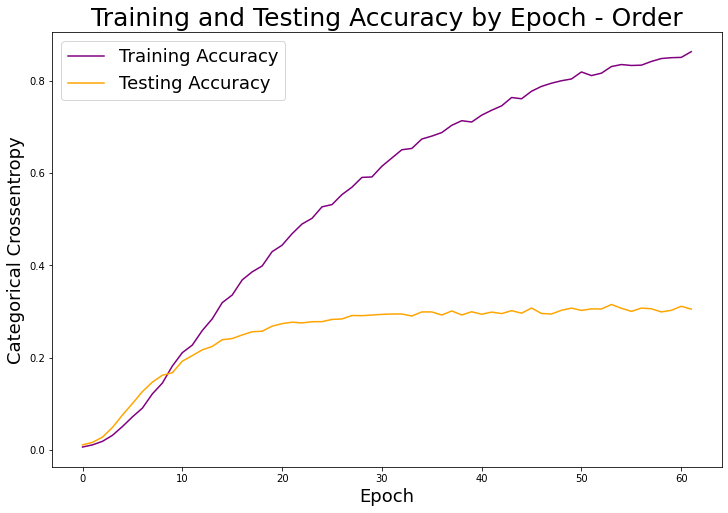

In [4]:
# Check out our train loss and test loss over epochs.
train_loss = history_t.history['accuracy']
test_loss = history_t.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Accuracy', color='purple')
plt.plot(test_loss, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch - Order', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)

plt.legend(fontsize = 18);

#### Insights:
* Once the model reached approximately 40 epochs, the testing accuracy gains decreased and it leveled off at roughly 28-30%. Early stopping ended the iteration at 62 epochs.
* Although I added drop out layers, our model was overfit, where training accuracy was roughly 99.83%. Regularization didn't improve the model's performance at the species level.

In [6]:
#save the model 
model_t.save('saved_models/species_t3.h5')

In [7]:
# read in class names for species, clean
species_class_names=[
"001.Black_footed_Albatross - 0.00509",
"002.Laysan_Albatross - 0.00509",
"003.Sooty_Albatross - 0.00492",
"004.Groove_billed_Ani - 0.00509",
"005.Crested_Auklet - 0.003733",
"006.Least_Auklet - 0.003478",
"007.Parakeet_Auklet - 0.004496",
"008.Rhinoceros_Auklet - 0.004072",
"009.Brewer_Blackbird - 0.005005",
"010.Red_winged_Blackbird - 0.00509",
"011.Rusty_Blackbird - 0.00509",
"012.Yellow_headed_Blackbird - 0.004751",
"013.Bobolink - 0.00509",
"014.Indigo_Bunting - 0.00509",
"015.Lazuli_Bunting - 0.00492",
"016.Painted_Bunting - 0.00492",
"017.Cardinal - 0.004835",
"018.Spotted_Catbird - 0.003817",
"019.Gray_Catbird - 0.005005",
"020.Yellow_breasted_Chat - 0.005005",
"021.Eastern_Towhee - 0.00509",
"022.Chuck_will_Widow - 0.004751",
"023.Brandt_Cormorant - 0.005005",
"024.Red_faced_Cormorant - 0.004411",
"025.Pelagic_Cormorant - 0.00509",
"026.Bronzed_Cowbird - 0.00509",
"027.Shiny_Cowbird - 0.00509",
"028.Brown_Creeper - 0.005005",
"029.American_Crow - 0.00509",
"030.Fish_Crow - 0.00509",
"031.Black_billed_Cuckoo - 0.00509",
"032.Mangrove_Cuckoo - 0.004496",
"033.Yellow_billed_Cuckoo - 0.005005",
"034.Gray_crowned_Rosy_Finch - 0.005005",
"035.Purple_Finch - 0.00509",
"036.Northern_Flicker - 0.00509",
"037.Acadian_Flycatcher - 0.005005",
"038.Great_Crested_Flycatcher - 0.00509",
"039.Least_Flycatcher - 0.005005",
"040.Olive_sided_Flycatcher - 0.00509",
"041.Scissor_tailed_Flycatcher - 0.00509",
"042.Vermilion_Flycatcher - 0.00509",
"043.Yellow_bellied_Flycatcher - 0.005005",
"044.Frigatebird - 0.00509",
"045.Northern_Fulmar - 0.00509",
"046.Gadwall - 0.00509",
"047.American_Goldfinch - 0.00509",
"048.European_Goldfinch - 0.00509",
"049.Boat_tailed_Grackle - 0.00509",
"050.Eared_Grebe - 0.00509",
"051.Horned_Grebe - 0.00509",
"052.Pied_billed_Grebe - 0.00509",
"053.Western_Grebe - 0.00509",
"054.Blue_Grosbeak - 0.00509",
"055.Evening_Grosbeak - 0.00509",
"056.Pine_Grosbeak - 0.00509",
"057.Rose_breasted_Grosbeak - 0.00509",
"058.Pigeon_Guillemot - 0.00492",
"059.California_Gull - 0.00509",
"060.Glaucous_winged_Gull - 0.005005",
"061.Heermann_Gull - 0.00509",
"062.Herring_Gull - 0.00509",
"063.Ivory_Gull - 0.00509",
"064.Ring_billed_Gull - 0.00509",
"065.Slaty_backed_Gull - 0.004242",
"066.Western_Gull - 0.00509",
"067.Anna_Hummingbird - 0.00509",
"068.Ruby_throated_Hummingbird - 0.00509",
"069.Rufous_Hummingbird - 0.00509",
"070.Green_Violetear - 0.00509",
"071.Long_tailed_Jaeger - 0.00509",
"072.Pomarine_Jaeger - 0.00509",
"073.Blue_Jay - 0.00509",
"074.Florida_Jay - 0.00509",
"075.Green_Jay - 0.004835",
"076.Dark_eyed_Junco - 0.00509",
"077.Tropical_Kingbird - 0.00509",
"078.Gray_Kingbird - 0.005005",
"079.Belted_Kingfisher - 0.00509",
"080.Green_Kingfisher - 0.00509",
"081.Pied_Kingfisher - 0.00509",
"082.Ringed_Kingfisher - 0.00509",
"083.White_breasted_Kingfisher - 0.00509",
"084.Red_legged_Kittiwake - 0.004496",
"085.Horned_Lark - 0.00509",
"086.Pacific_Loon - 0.00509",
"087.Mallard - 0.00509",
"088.Western_Meadowlark - 0.00509",
"089.Hooded_Merganser - 0.00509",
"090.Red_breasted_Merganser - 0.00509",
"091.Mockingbird - 0.00509",
"092.Nighthawk - 0.00509",
"093.Clark_Nutcracker - 0.00509",
"094.White_breasted_Nuthatch - 0.00509",
"095.Baltimore_Oriole - 0.00509",
"096.Hooded_Oriole - 0.00509",
"097.Orchard_Oriole - 0.005005",
"098.Scott_Oriole - 0.00509",
"099.Ovenbird - 0.00509",
"100.Brown_Pelican - 0.00509",
"101.White_Pelican - 0.004242",
"102.Western_Wood_Pewee - 0.00509",
"103.Sayornis - 0.00509",
"104.American_Pipit - 0.00509",
"105.Whip_poor_Will - 0.004157",
"106.Horned_Puffin - 0.00509",
"107.Common_Raven - 0.005005",
"108.White_necked_Raven - 0.00509",
"109.American_Redstart - 0.00509",
"110.Geococcyx - 0.00509",
"111.Loggerhead_Shrike - 0.00509",
"112.Great_Grey_Shrike - 0.00509",
"113.Baird_Sparrow - 0.004242",
"114.Black_throated_Sparrow - 0.00509",
"115.Brewer_Sparrow - 0.005005",
"116.Chipping_Sparrow - 0.00509",
"117.Clay_colored_Sparrow - 0.005005",
"118.House_Sparrow - 0.00509",
"119.Field_Sparrow - 0.005005",
"120.Fox_Sparrow - 0.00509",
"121.Grasshopper_Sparrow - 0.00509",
"122.Harris_Sparrow - 0.00509",
"123.Henslow_Sparrow - 0.00509",
"124.Le_Conte_Sparrow - 0.005005",
"125.Lincoln_Sparrow - 0.005005",
"126.Nelson_Sharp_tailed_Sparrow - 0.005005",
"127.Savannah_Sparrow - 0.00509",
"128.Seaside_Sparrow - 0.00509",
"129.Song_Sparrow - 0.00509",
"130.Tree_Sparrow - 0.00509",
"131.Vesper_Sparrow - 0.00509",
"132.White_crowned_Sparrow - 0.00509",
"133.White_throated_Sparrow - 0.00509",
"134.Cape_Glossy_Starling - 0.00509",
"135.Bank_Swallow - 0.005005",
"136.Barn_Swallow - 0.00509",
"137.Cliff_Swallow - 0.00509",
"138.Tree_Swallow - 0.00509",
"139.Scarlet_Tanager - 0.00509",
"140.Summer_Tanager - 0.00509",
"141.Artic_Tern - 0.00492",
"142.Black_Tern - 0.00509",
"143.Caspian_Tern - 0.00509",
"144.Common_Tern - 0.00509",
"145.Elegant_Tern - 0.00509",
"146.Forsters_Tern - 0.00509",
"147.Least_Tern - 0.00509",
"148.Green_tailed_Towhee - 0.00509",
"149.Brown_Thrasher - 0.005005",
"150.Sage_Thrasher - 0.00509",
"151.Black_capped_Vireo - 0.004326",
"152.Blue_headed_Vireo - 0.00509",
"153.Philadelphia_Vireo - 0.005005",
"154.Red_eyed_Vireo - 0.00509",
"155.Warbling_Vireo - 0.00509",
"156.White_eyed_Vireo - 0.00509",
"157.Yellow_throated_Vireo - 0.005005",
"158.Bay_breasted_Warbler - 0.00509",
"159.Black_and_white_Warbler - 0.00509",
"160.Black_throated_Blue_Warbler - 0.005005",
"161.Blue_winged_Warbler - 0.00509",
"162.Canada_Warbler - 0.00509",
"163.Cape_May_Warbler - 0.00509",
"164.Cerulean_Warbler - 0.00509",
"165.Chestnut_sided_Warbler - 0.00509",
"166.Golden_winged_Warbler - 0.005005",
"167.Hooded_Warbler - 0.00509",
"168.Kentucky_Warbler - 0.005005",
"169.Magnolia_Warbler - 0.005005",
"170.Mourning_Warbler - 0.00509",
"171.Myrtle_Warbler - 0.00509",
"172.Nashville_Warbler - 0.00509",
"173.Orange_crowned_Warbler - 0.00509",
"174.Palm_Warbler - 0.00509",
"175.Pine_Warbler - 0.00509",
"176.Prairie_Warbler - 0.00509",
"177.Prothonotary_Warbler - 0.00509",
"178.Swainson_Warbler - 0.004751",
"179.Tennessee_Warbler - 0.005005",
"180.Wilson_Warbler - 0.00509",
"181.Worm_eating_Warbler - 0.005005",
"182.Yellow_Warbler - 0.00509",
"183.Northern_Waterthrush - 0.00509",
"184.Louisiana_Waterthrush - 0.00509",
"185.Bohemian_Waxwing - 0.00509",
"186.Cedar_Waxwing - 0.00509",
"187.American_Three_toed_Woodpecker - 0.004242",
"188.Pileated_Woodpecker - 0.00509",
"189.Red_bellied_Woodpecker - 0.00509",
"190.Red_cockaded_Woodpecker - 0.00492",
"191.Red_headed_Woodpecker - 0.00509",
"192.Downy_Woodpecker - 0.00509",
"193.Bewick_Wren - 0.00509",
"194.Cactus_Wren - 0.00509",
"195.Carolina_Wren - 0.00509",
"196.House_Wren - 0.005005",
"197.Marsh_Wren - 0.00509",
"198.Rock_Wren - 0.00509",
"199.Winter_Wren - 0.00509",
"200.Common_Yellowthroat - 0.00509"

]

formatted_species_names=[i.split("-", 1)[0].split(".", 1)[1].replace("_", " ") for i in species_class_names]

In [8]:
# Prep data for confusion matrix
predictions=model_t.predict(X_test_alt) 
pred_f=np.argmax(predictions,axis=1)
y_test_f=np.argmax(y_test_alt,axis=1)

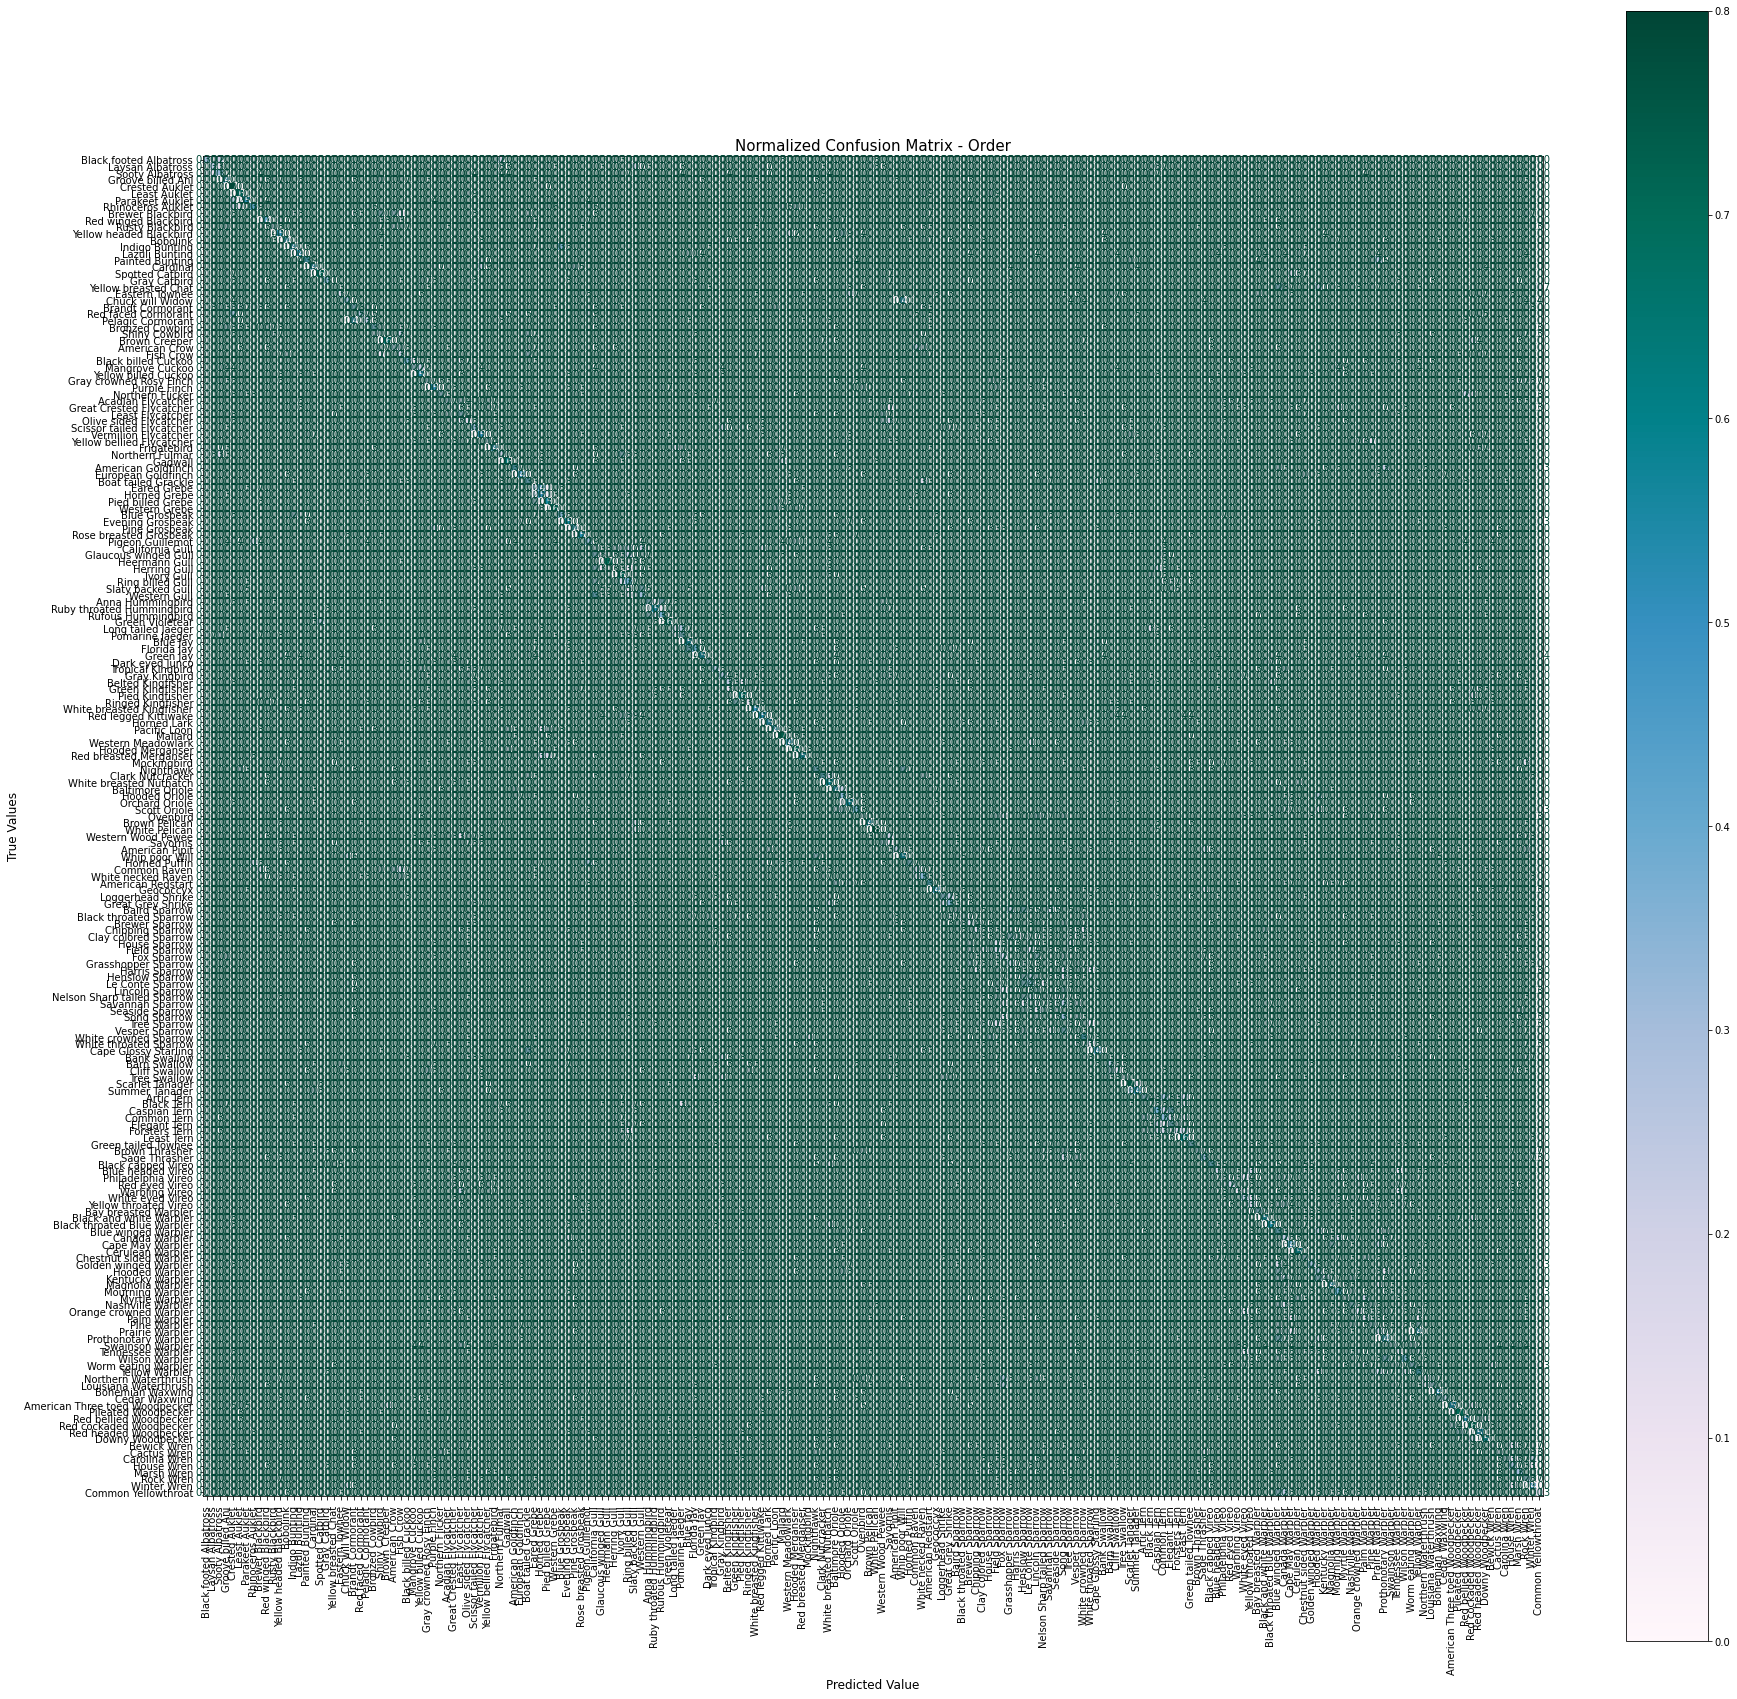

In [9]:
# build normalized confusion matrix display
cm = metrics.confusion_matrix(y_test_f, pred_f, normalize='true') #set normalize = true to see the % distribution by row 
fig, ax = plt.subplots(figsize=(30, 30))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=formatted_species_names)
ax.set_title('Normalized Confusion Matrix - Order', fontsize=15)
disp.plot(ax=ax, cmap='PuBuGn',values_format='.2f')
plt.xticks(rotation=90)
plt.xlabel('Predicted Value', fontsize = 12)
plt.ylabel('True Values', fontsize = 12);